In [6]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import  StandardScaler, OrdinalEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import (accuracy_score,
                             roc_auc_score, 
                             roc_curve,
                             precision_score, 
                             recall_score, 
                             f1_score, 
                             classification_report, 
                             confusion_matrix)
from tqdm import tqdm

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

In [7]:
# 1. Đọc dữ liệu
df_train = pd.read_parquet('train.parquet')
df_valid = pd.read_parquet('validation.parquet')
df_test  = pd.read_parquet('test.parquet')

In [3]:



# 2. Cột loại bỏ
cols_to_drop = [
    'fraud',
    'ngay_hhluc_khang', 'ngay_hhluc_vitri_ddo', 'ngay_hhluc_diemdo', 'ngay_hhluc',
    'id_bcs', 'ngay_kdinh', 'loai_chiso', 'ngay_hluc_diem_do', 'ngay_hluc_vitri_ddo',
    'thang_csuat_ddo', 'ngay_hluc_khang', 'gia_tri', 'loai_giatri', 'kimua_cspk',
    'id_ddo', 'ma_dviqly', 'so_cot', 'so_hop', 'ma_dvictren', 'ky', 'thang', 'nam',
    'sluong_ttiep', 'sluong_trphu', 'thd_le', 'ma_cnang_chiso', 'ngay_bdong',
    'id_khang', 'so_pha', 'ngay_tao_chiso', 'nguoi_tao_chiso', 'ngay_sua_chiso',
    'nguoi_sua_chiso', 'ngay_hluc'
]

# 3. Tách X, y
X_train = df_train.drop(columns=cols_to_drop)
y_train = df_train['fraud']
X_valid = df_valid.drop(columns=cols_to_drop)
y_valid = df_valid['fraud']
X_test = df_test.drop(columns=cols_to_drop)
y_test = df_test['fraud']

# CatBoost

In [4]:
from sklearn.base import BaseEstimator, TransformerMixin
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

# Tao custom metrix
def custom_metric(estimator, X, y_true):
    y_hat = estimator.predict_proba(X)[:, 1]
    min_tpr = 0.80
    max_fpr = abs(1 - min_tpr)
    
    v_gt = abs(y_true - 1)
    v_pred = np.array([1.0 - x for x in y_hat])
    
    partial_auc_scaled = roc_auc_score(v_gt, v_pred, max_fpr=max_fpr)
    partial_auc = 0.5 * max_fpr**2 + (max_fpr - 0.5 * max_fpr**2) / (1.0 - 0.5) * (partial_auc_scaled - 0.5)
    
    return partial_auc

# Tạo custom transformer để thực hiện oversampling và undersampling
class ResampleTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, oversampler, undersampler):
        self.oversampler = oversampler
        self.undersampler = undersampler

    def fit(self, X, y):
        # Không cần fit gì ở đây, chỉ cần trả về chính X, y
        return self

    def transform(self, X, y=None):
        # Áp dụng oversampling rồi đến undersampling nếu y không phải None
        if y is not None:
            X_res, y_res = self.oversampler.fit_resample(X, y)
            X_res, y_res = self.undersampler.fit_resample(X_res, y_res)
            return X_res, y_res
        return X  # Nếu y là None, chỉ trả về X


In [5]:
from catboost import CatBoostClassifier
from sklearn.model_selection import StratifiedKFold, cross_validate
from sklearn.pipeline import Pipeline
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

SEED = 42
cb_params = {
    'loss_function':     'Logloss',
    'iterations':        250,
    'verbose':           False,
    'random_state':      SEED,
    'max_depth':         7,
    'learning_rate':     0.06936242010150652,
    'scale_pos_weight':  2.6149345838209532,
    'l2_leaf_reg':       6.216113851699493,
    'subsample':         0.6249261779711819,
    'min_data_in_leaf':  24,
    # 'cat_features':      cat_cols,
}


# Chuẩn bị dữ liệu
X = pd.concat([X_train, X_valid], axis=0)
y = pd.concat([y_train, y_valid], axis=0)

# Sử dụng StratifiedKFold để đảm bảo tỷ lệ lớp
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)

# Khởi tạo mô hình CatBoost với các siêu tham số tốt nhất
model = CatBoostClassifier(**cb_params)

# Khởi tạo các phương pháp resampling
oversampler = RandomOverSampler(sampling_strategy=0.03, random_state=SEED)
undersampler = RandomUnderSampler(sampling_strategy=0.03, random_state=SEED)

# Tạo pipeline hoàn chỉnh sử dụng custom transformer
full_pipeline = Pipeline([
    ('resample', ResampleTransformer(oversampler, undersampler)),
    ('model', model)
])

# Đánh giá mô hình bằng cross-validation với custom transformer
print("Performing cross-validation with Augmentation...")
cross_val_results = cross_validate(
    full_pipeline,
    X,
    y,
    cv=skf,
    scoring=custom_metric,
    verbose=1
)

# In ra kết quả cross-validation
print(f'Cross-validation pAUC scores: {cross_val_results["test_score"]}')
print(f'Mean pAUC: {cross_val_results["test_score"].mean():.4f}, Std: {cross_val_results["test_score"].std():.4f}')

# Huấn luyện mô hình cuối cùng trên toàn bộ dữ liệu
print("Training final model on the entire combined dataset...")
full_pipeline.fit(X, y)


Performing cross-validation with Augmentation...


KeyboardInterrupt: 

In [ ]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_auc_score, confusion_matrix

y_pred = full_pipeline.predict(X_test)
y_pred_proba = full_pipeline.predict_proba(X_test)[:, 1]  # Xác suất của lớp dương

# Đánh giá mô hình
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)
conf_matrix = confusion_matrix(y_test, y_pred)

# In kết quả đánh giá
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")
print(f"ROC AUC: {roc_auc:.4f}")
print("Confusion Matrix:")
print(conf_matrix)


Accuracy: 0.9915
Precision: 0.6068
Recall: 0.9228
F1-Score: 0.7322
ROC AUC: 0.9978
Confusion Matrix:
[[4345914   33584]
 [   4334   51829]]


In [ ]:
oversampler = RandomOverSampler(sampling_strategy=0.03, random_state=SEED)
undersampler = RandomUnderSampler(sampling_strategy=0.03, random_state=SEED)

In [ ]:
resample = ResampleTransformer(oversampler, undersampler)
X_train_res, y_train_res = resample.transform(X_train, y_train)
#print(np.bincount(y_train_res))

In [ ]:
from catboost import CatBoostClassifier, Pool

# === Khởi tạo model ===
model = CatBoostClassifier(
    **cb_params,           
    eval_metric='Logloss', 
    custom_metric='Accuracy',
    early_stopping_rounds=30,
    
)

# === Tạo Pool ===
train_pool = Pool(X_train_res, y_train_res)
valid_pool = Pool(X_valid, y_valid)

# === Train model ===
model.fit(
    train_pool,
    eval_set=valid_pool
)


In [ ]:
# Lấy kết quả huấn luyện
evals_result = model.evals_result_

# In tất cả các metric được ghi lại
print("Các metric đã được lưu:")
for key in evals_result['learn'].keys():
    print(f"- {key}")


Các metric đã được lưu:
- Accuracy:use_weights=true
- Logloss
- Accuracy:use_weights=false


In [ ]:
# Trích xuất log từ model
evals_result = model.evals_result_

In [ ]:
print(evals_result.keys()) 

dict_keys(['learn', 'validation'])


In [ ]:


train_loss = evals_result['learn']['Logloss']
val_loss   = evals_result['validation']['Logloss']

train_acc = evals_result['learn']['Accuracy:use_weights=false']
val_acc   = evals_result['validation']['Accuracy:use_weights=false']


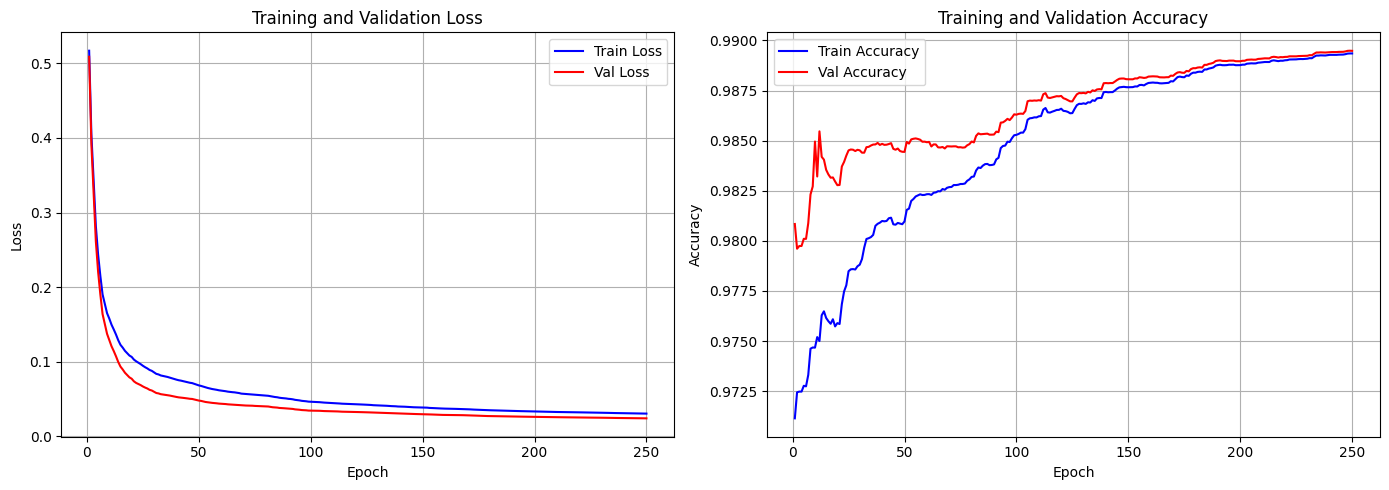

In [ ]:
import matplotlib.pyplot as plt

# Epochs
epochs = range(1, len(train_loss) + 1)

# Vẽ
plt.figure(figsize=(14, 5))

# Loss subplot
plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss, 'b', label='Train Loss')
plt.plot(epochs, val_loss, 'r', label='Val Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Accuracy subplot
plt.subplot(1, 2, 2)
plt.plot(epochs, train_acc, 'b', label='Train Accuracy')
plt.plot(epochs, val_acc, 'r', label='Val Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.99      1.00   4379497
           1       0.59      0.93      0.72     56164

    accuracy                           0.99   4435661
   macro avg       0.79      0.96      0.86   4435661
weighted avg       0.99      0.99      0.99   4435661



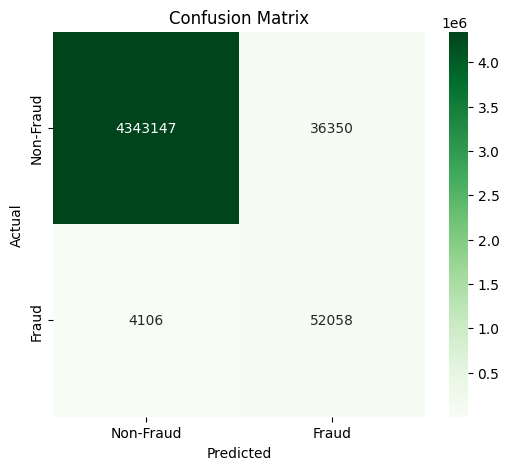

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Dự đoán trên tập test
y_pred = full_pipeline.predict(X_test)

# Đánh giá mô hình với classification report và confusion matrix
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Vẽ confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens', xticklabels=['Non-Fraud', 'Fraud'], yticklabels=['Non-Fraud', 'Fraud'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


In [ ]:
# Định nghĩa độ đo tùy chỉnh (Partial AUC)
def custom_metric(y_true, y_pred_proba):
    min_tpr = 0.80  # Ngưỡng TPR tối thiểu
    max_fpr = abs(1 - min_tpr)  # Ngưỡng FPR tối đa
    
    v_gt = abs(y_true - 1)  # Chuyển đổi y_true thành lớp tích cực (1) và lớp tiêu cực (0)
    v_pred = np.array([1.0 - x for x in y_pred_proba])  # Chuyển đổi xác suất dự đoán thành lớp tiêu cực
    
    partial_auc_scaled = roc_auc_score(v_gt, v_pred, max_fpr=max_fpr)  # Tính AUC của phần có FPR giới hạn
    partial_auc = 0.5 * max_fpr**2 + (max_fpr - 0.5 * max_fpr**2) / (1.0 - 0.5) * (partial_auc_scaled - 0.5)  # Điều chỉnh AUC

    return partial_auc

# Lấy xác suất dự đoán của lớp tích cực (Fraud)
y_pred_proba = full_pipeline.predict_proba(X_test)[:, 1]  # Dự đoán xác suất lớp tích cực (Fraud)

# Tính độ đo tùy chỉnh trên tập test
custom_auc_score = custom_metric(y_test, y_pred_proba)

# In kết quả độ đo tùy chỉnh
print(f'Custom pAUC Score: {custom_auc_score}')
print(f'AUC Score: {roc_auc_score(y_test, y_pred_proba)}')


Custom pAUC Score: 0.19840264156250428
AUC Score: 0.9975912253666265


Text(0, 0.5, 'True Positive Rate')

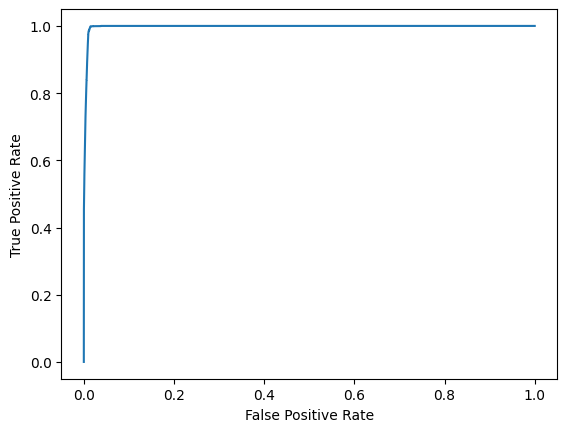

In [ ]:
# Ve ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

In [ ]:
Features = [col for col in data.columns if col not in cols_to_drop]
print(Features)

['id_chiso', 'ma_ddo', 'bcs_chiso', 'hs_nhan', 'so_cto_chiso', 'chiso_cu', 'chiso_moi', 'san_luong', 'ma_ttcto', 'ngay_dky', 'ngay_cky', 'sluong_1', 'sluong_2', 'sluong_3', 'ma_tram', 'ma_cto', 'so_cto_hso_cto', 'ma_bdong', 'dong_dien', 'dien_ap', 'vh_cong', 'ma_cloai', 'ten_khang', 'ma_khang', 'dia_chi', 'csuat', 'so_cto_csuat_ddo']


C:\Users\HOME\AppData\Local\Temp\ipykernel_6704\3266474647.py:6: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  s.set_xticklabels(s.get_xticklabels(),rotation=90)


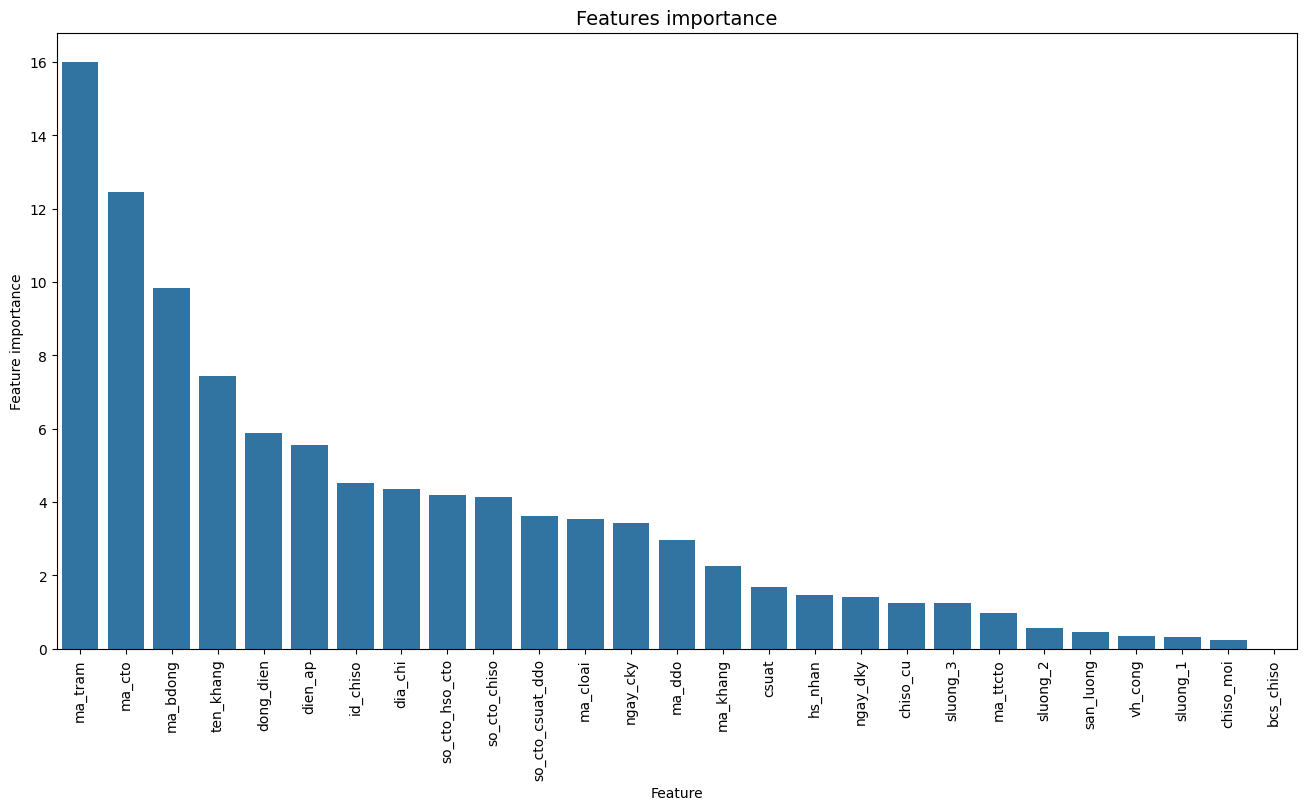

In [ ]:

tmp = pd.DataFrame({'Feature': Features, 'Feature importance': model.feature_importances_})
tmp = tmp.sort_values(by='Feature importance',ascending=False)
plt.figure(figsize = (16,8))
plt.title('Features importance',fontsize=14)
s = sns.barplot(x='Feature',y='Feature importance',data=tmp)
s.set_xticklabels(s.get_xticklabels(),rotation=90)
plt.show()

In [ ]:
from sklearn.metrics import roc_curve, auc
import numpy as np
import matplotlib.pyplot as plt

def compute_pAUC(y_true, y_scores, max_fpr=0.2, plot=True):
    """
    Tính partial AUC cho FPR <= max_fpr.
    Parameters:
        y_true (array): Nhãn thực tế (0 hoặc 1)
        y_scores (array): Xác suất dự đoán cho lớp dương (fraud)
        max_fpr (float): Ngưỡng tối đa của FPR
        plot (bool): Nếu True thì vẽ biểu đồ ROC giới hạn
        
    Returns:
        pAUC (float): Giá trị partial AUC đã chuẩn hóa
    """
    fpr, tpr, _ = roc_curve(y_true, y_scores)

    # Lọc phần đường cong có FPR <= max_fpr
    mask = fpr <= max_fpr
    fpr_part = fpr[mask]
    tpr_part = tpr[mask]

    # Nội suy nếu cần thêm điểm tại max_fpr
    if fpr_part[-1] < max_fpr:
        next_idx = np.searchsorted(fpr, max_fpr)
        fpr_interp = max_fpr
        tpr_interp = np.interp(max_fpr, [fpr[next_idx - 1], fpr[next_idx]], [tpr[next_idx - 1], tpr[next_idx]])
        fpr_part = np.append(fpr_part, fpr_interp)
        tpr_part = np.append(tpr_part, tpr_interp)

    # Tính diện tích AUC trong đoạn FPR <= max_fpr
    pAUC_raw = auc(fpr_part, tpr_part)
    pAUC_normalized = pAUC_raw / max_fpr  # Chuẩn hóa về [0, 1]

    # Vẽ biểu đồ nếu cần
    if plot:
        plt.figure(figsize=(6,5))
        plt.plot(fpr, tpr, label='Full ROC', linestyle='--', color='gray')
        plt.plot(fpr_part, tpr_part, label=f'Partial ROC (FPR ≤ {max_fpr})', color='green')
        plt.fill_between(fpr_part, tpr_part, alpha=0.3, color='green')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title(f'Partial AUC (FPR ≤ {max_fpr}): {pAUC_normalized:.4f}')
        plt.legend(loc='lower right')
        plt.grid(True)
        plt.show()

    return pAUC_normalized


In [ ]:
# Tính tỉ lệ lớp Fraud trong tập train và test
train_ratio = y_train.mean()
test_ratio = y_test.mean()

print(f"Tỉ lệ Fraud trong tập TRAIN: {train_ratio:.4f} ({train_ratio*100:.2f}%)")
print(f"Tỉ lệ Fraud trong tập TEST:  {test_ratio:.4f} ({test_ratio*100:.2f}%)")


Tỉ lệ Fraud trong tập TRAIN: 0.0127 (1.27%)
Tỉ lệ Fraud trong tập TEST:  0.0127 (1.27%)


In [ ]:
# Tính tỷ lệ lớp trong tập huấn luyện và tập kiểm tra
train_class_distribution = y_train.value_counts(normalize=True)
test_class_distribution = y_test.value_counts(normalize=True)

print("Tỉ lệ các lớp trong tập TRAIN:")
print(train_class_distribution)
print("\nTỉ lệ các lớp trong tập TEST:")
print(test_class_distribution)


Tỉ lệ các lớp trong tập TRAIN:
fraud
0    0.987338
1    0.012662
Name: proportion, dtype: float64

Tỉ lệ các lớp trong tập TEST:
fraud
0    0.987338
1    0.012662
Name: proportion, dtype: float64


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

def compute_pAUC_TPR_and_FPR(y_true, y_scores, tpr_threshold=0.8, fpr_threshold=0.2, plot=True):
    """
    Tính và vẽ pAUC trong vùng TPR ≥ threshold và FPR ≤ threshold.

    Args:
        y_true: Ground truth labels (0/1)
        y_scores: Probabilities predicted for positive class
        tpr_threshold: TPR lower bound
        fpr_threshold: FPR upper bound
        plot: Whether to plot the ROC and pAUC region

    Returns:
        pAUC value in the defined region
    """
    # Tính ROC
    fpr, tpr, _ = roc_curve(y_true, y_scores)
    full_auc = auc(fpr, tpr)

    # Chọn các điểm thỏa cả 2 điều kiện
    mask = (tpr >= tpr_threshold) & (fpr <= fpr_threshold)
    fpr_pauc = fpr[mask]
    tpr_pauc = tpr[mask]

    # Tính diện tích pAUC nếu có đủ điểm
    pauc = auc(fpr_pauc, tpr_pauc) if len(fpr_pauc) > 1 else 0.0

    if plot:
        plt.figure(figsize=(6, 6))
        plt.plot(fpr, tpr, color='blue', label=f'ROC (AUC = {full_auc:.3f})')

        # Tô vùng giao TPR ≥ tpr_threshold và FPR ≤ fpr_threshold
        if len(fpr_pauc) > 1:
            plt.fill_between(fpr_pauc, tpr_pauc, tpr_threshold, color='blue', alpha=0.3,
                             label=f'pAUC (TPR ≥ {tpr_threshold}, FPR ≤ {fpr_threshold})')

        # Kẻ đường tham chiếu
        plt.axhline(y=tpr_threshold, color='black', linestyle='--', label=f'TPR = {tpr_threshold}')
        plt.axvline(x=fpr_threshold, color='red', linestyle='--', label=f'FPR = {fpr_threshold}')

        plt.xlabel('False Positive Rate (FPR)')
        plt.ylabel('True Positive Rate (TPR)')
        plt.title('pAUC in Region (TPR ≥ 0.8, FPR ≤ 0.2)')
        plt.grid(True)
        plt.legend(loc='lower right')
        plt.tight_layout()
        plt.show()

    return pauc


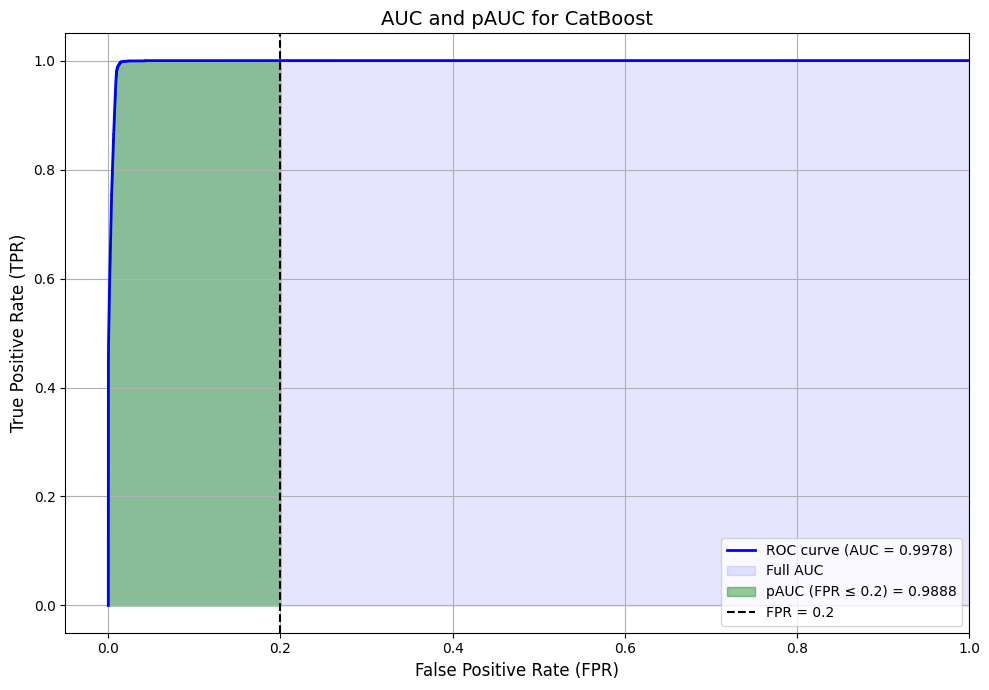

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Dữ liệu đầu vào (đã train model)
y_true = y  # true labels
y_scores = full_pipeline.predict_proba(X)[:, 1]  # xác suất nhãn 1 (fraud)

# Tính ROC curve và AUC
fpr, tpr, _ = roc_curve(y_true, y_scores)
roc_auc = auc(fpr, tpr)

# Tính pAUC với FPR ≤ 0.2
max_fpr = 0.2
mask = fpr <= max_fpr
fpr_trunc = fpr[mask]
tpr_trunc = tpr[mask]

# Nội suy thêm điểm tại FPR = 0.2 nếu cần
if fpr_trunc[-1] < max_fpr and len(fpr_trunc) > 1:
    slope = (tpr_trunc[-1] - tpr_trunc[-2]) / (fpr_trunc[-1] - fpr_trunc[-2])
    tpr_at_02 = tpr_trunc[-1] + slope * (max_fpr - fpr_trunc[-1])
    fpr_trunc = np.append(fpr_trunc, max_fpr)
    tpr_trunc = np.append(tpr_trunc, tpr_at_02)

pauc = auc(fpr_trunc, tpr_trunc)
pauc_normalized = pauc / max_fpr

# Vẽ biểu đồ
plt.figure(figsize=(10, 7))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.4f})')

# Full AUC background
plt.fill_between(fpr, tpr, alpha=0.1, color='blue', label='Full AUC')

# pAUC highlight
plt.fill_between(fpr_trunc, tpr_trunc, alpha=0.4, color='green',
                 label=f'pAUC (FPR ≤ {max_fpr}) = {pauc_normalized:.4f}')

# FPR = 0.2 line
plt.axvline(x=max_fpr, color='black', linestyle='--', label=f'FPR = {max_fpr}')

# Trang trí
plt.xlabel('False Positive Rate (FPR)', fontsize=12)
plt.ylabel('True Positive Rate (TPR)', fontsize=12)
plt.title('AUC and pAUC for CatBoost', fontsize=14)
plt.xlim([-0.05, 1.0])
plt.ylim([-0.05, 1.05])
plt.grid(True)
plt.legend(loc='lower right', fontsize=10)
plt.tight_layout()
plt.show()


preprocessing

In [8]:
# Cột loại bỏ trước huấn luyện
cols_to_drop = [
    'fraud',
    'ngay_hhluc_khang', 'ngay_hhluc_vitri_ddo', 'ngay_hhluc_diemdo', 'ngay_hhluc',
    'id_bcs', 'ngay_kdinh', 'loai_chiso', 'ngay_hluc_diem_do', 'ngay_hluc_vitri_ddo',
    'thang_csuat_ddo', 'ngay_hluc_khang', 'gia_tri', 'loai_giatri', 'kimua_cspk',
    'id_ddo', 'ma_dviqly', 'so_cot', 'so_hop', 'ma_dvictren', 'ky', 'thang', 'nam',
    'sluong_ttiep', 'sluong_trphu', 'thd_le', 'ma_cnang_chiso', 'ngay_bdong',
    'id_khang', 'so_pha', 'ngay_tao_chiso', 'nguoi_tao_chiso', 'ngay_sua_chiso',
    'nguoi_sua_chiso', 'ngay_hluc'
]

# Tách X, y
X_train = df_train.drop(columns=cols_to_drop)
y_train = df_train['fraud']
X_valid = df_valid.drop(columns=cols_to_drop)
y_valid = df_valid['fraud']
X_test = df_test.drop(columns=cols_to_drop)
y_test = df_test['fraud']

# Mã hóa object
cat_cols = X_train.select_dtypes(include=['object']).columns.tolist()
oe = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
X_train[cat_cols] = oe.fit_transform(X_train[cat_cols].astype(str))
X_valid[cat_cols] = oe.transform(X_valid[cat_cols].astype(str))
X_test[cat_cols]  = oe.transform(X_test[cat_cols].astype(str))

In [9]:
#from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from catboost import CatBoostClassifier
SEED = 42
cb_params = {
    'loss_function':     'Logloss',
    'iterations':        250,
    'verbose':           False,
    'random_state':      SEED,
    'max_depth':         7,
    'learning_rate':     0.06936242010150652,
    'scale_pos_weight':  2.6149345838209532,
    'l2_leaf_reg':       6.216113851699493,
    'subsample':         0.6249261779711819,
    'min_data_in_leaf':  24,
    # 'cat_features':      cat_cols,
}
cb_model = CatBoostClassifier(**cb_params)

cb_model.fit(
    X_train, y_train,
    eval_set=[(X_valid, y_valid)],
    
    verbose=True
)

# Dự đoán
y_pred_proba = cb_model.predict_proba(X_test)[:, 1]
y_pred = cb_model.predict(X_test)


0:	learn: 0.4949994	test: 0.4948880	best: 0.4948880 (0)	total: 1.87s	remaining: 7m 44s
1:	learn: 0.3618598	test: 0.3616672	best: 0.3616672 (1)	total: 3.62s	remaining: 7m 28s
2:	learn: 0.2655857	test: 0.2654448	best: 0.2654448 (2)	total: 5.34s	remaining: 7m 19s
3:	learn: 0.2138456	test: 0.2137513	best: 0.2137513 (3)	total: 7.1s	remaining: 7m 16s
4:	learn: 0.1835992	test: 0.1835220	best: 0.1835220 (4)	total: 8.91s	remaining: 7m 16s
5:	learn: 0.1619794	test: 0.1618922	best: 0.1618922 (5)	total: 10.6s	remaining: 7m 10s
6:	learn: 0.1445254	test: 0.1444170	best: 0.1444170 (6)	total: 12.3s	remaining: 7m 7s
7:	learn: 0.1287911	test: 0.1286609	best: 0.1286609 (7)	total: 14s	remaining: 7m 2s
8:	learn: 0.1159551	test: 0.1157985	best: 0.1157985 (8)	total: 15.8s	remaining: 7m 2s
9:	learn: 0.1059641	test: 0.1058029	best: 0.1058029 (9)	total: 17.6s	remaining: 7m 2s
10:	learn: 0.0956733	test: 0.0955028	best: 0.0955028 (10)	total: 19.3s	remaining: 6m 59s
11:	learn: 0.0895910	test: 0.0894152	best: 0.089

KeyboardInterrupt: 

In [ ]:
# Định nghĩa độ đo tùy chỉnh (Partial AUC)
def custom_metric(y_true, y_pred_proba):
    min_tpr = 0.80  # Ngưỡng TPR tối thiểu
    max_fpr = abs(1 - min_tpr)  # Ngưỡng FPR tối đa
    
    v_gt = abs(y_true - 1)  # Chuyển đổi y_true thành lớp tích cực (1) và lớp tiêu cực (0)
    v_pred = np.array([1.0 - x for x in y_pred_proba])  # Chuyển đổi xác suất dự đoán thành lớp tiêu cực
    
    partial_auc_scaled = roc_auc_score(v_gt, v_pred, max_fpr=max_fpr)  # Tính AUC của phần có FPR giới hạn
    partial_auc = 0.5 * max_fpr**2 + (max_fpr - 0.5 * max_fpr**2) / (1.0 - 0.5) * (partial_auc_scaled - 0.5)  # Điều chỉnh AUC

    return partial_auc

# Lấy xác suất dự đoán của lớp tích cực (Fraud)
#y_pred_proba = model_raw.predict_proba(X_test_raw)[:, 1]  # Dự đoán xác suất lớp tích cực (Fraud)

# Tính độ đo tùy chỉnh trên tập test
custom_auc_score = custom_metric(y_test_raw, y_pred_proba_raw)

# In kết quả độ đo tùy chỉnh
print(f'Custom pAUC Score: {custom_auc_score}')
print(f'AUC Score: {roc_auc_score(y_test_raw, y_pred_proba_raw)}')

Custom pAUC Score: 0.19985807318642534
AUC Score: 0.9998470828581899


AUC Score      : 0.99752
Custom pAUC    : 0.19837


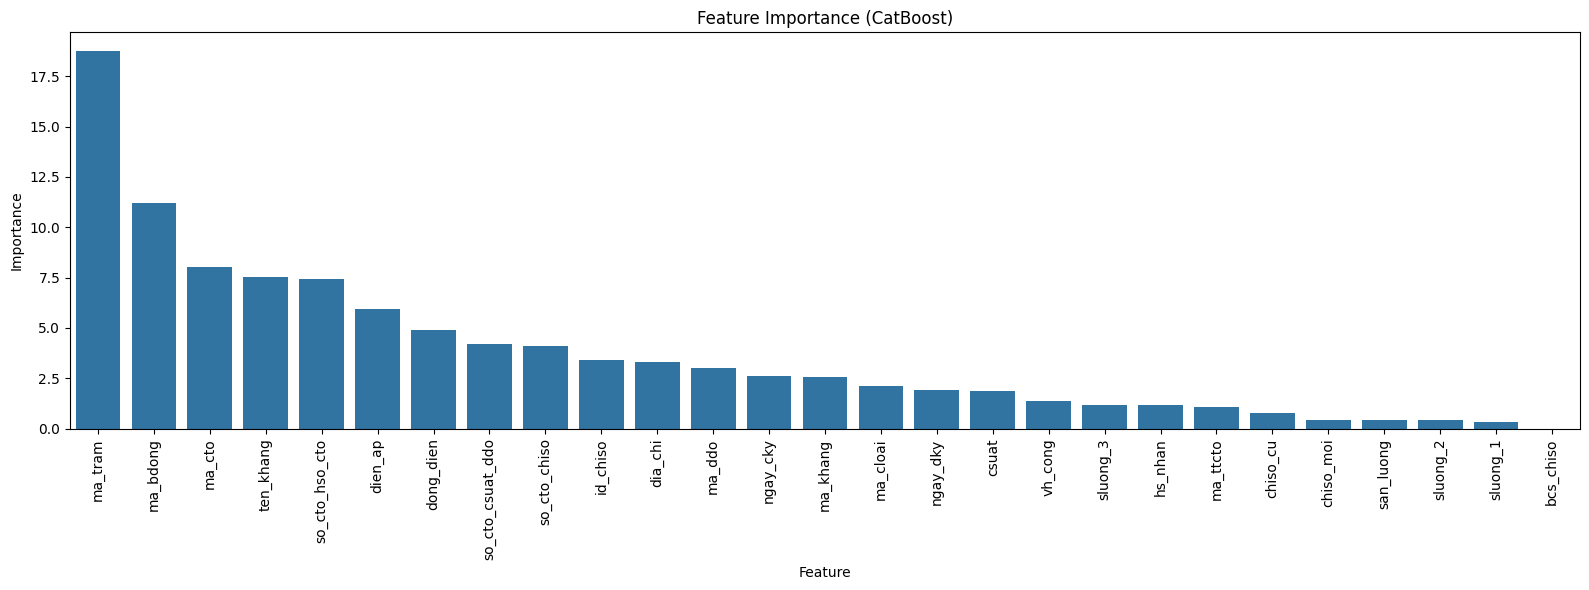

In [10]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import OrdinalEncoder
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns
from catboost import CatBoostClassifier

#  1. Đọc 3 tập dữ liệu 
df_train = pd.read_parquet('trainn.parquet')
df_valid = pd.read_parquet('vali.parquet')
df_test  = pd.read_parquet('testt.parquet')

#  2. Danh sách cột cần loại bỏ 
cols_to_drop = [
    'fraud',
    'ngay_hhluc_khang', 'ngay_hhluc_vitri_ddo', 'ngay_hhluc_diemdo', 'ngay_hhluc',
    'id_bcs', 'ngay_kdinh', 'loai_chiso', 'ngay_hluc_diem_do', 'ngay_hluc_vitri_ddo',
    'thang_csuat_ddo', 'ngay_hluc_khang', 'gia_tri', 'loai_giatri', 'kimua_cspk',
    'id_ddo', 'ma_dviqly', 'so_cot', 'so_hop', 'ma_dvictren', 'ky', 'thang', 'nam',
    'sluong_ttiep', 'sluong_trphu', 'thd_le', 'ma_cnang_chiso', 'ngay_bdong',
    'id_khang', 'so_pha', 'ngay_tao_chiso', 'nguoi_tao_chiso', 'ngay_sua_chiso',
    'nguoi_sua_chiso', 'ngay_hluc'
]

#  3. Tách X và y 
X_train = df_train.drop(columns=cols_to_drop)
y_train = df_train['fraud']

X_valid = df_valid.drop(columns=cols_to_drop)
y_valid = df_valid['fraud']

X_test = df_test.drop(columns=cols_to_drop)
y_test = df_test['fraud']

#  4. Mã hóa các cột object 
cat_cols = X_train.select_dtypes(include=['object']).columns.tolist()
oe = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
X_train[cat_cols] = oe.fit_transform(X_train[cat_cols].astype(str))
X_valid[cat_cols] = oe.transform(X_valid[cat_cols].astype(str))
X_test[cat_cols]  = oe.transform(X_test[cat_cols].astype(str))

#  5. Cấu hình CatBoost và huấn luyện với early stopping 
SEED = 42
cb_params = {
    'loss_function':     'Logloss',
    'iterations':        250,
    'verbose':           False,
    'random_state':      SEED,
    'max_depth':         7,
    'learning_rate':     0.06936242010150652,
    'scale_pos_weight':  2.6149345838209532,
    'l2_leaf_reg':       6.216113851699493,
    'subsample':         0.6249261779711819,
    'min_data_in_leaf':  24
}

model = CatBoostClassifier(**cb_params)

model.fit(
    X_train, y_train,
    eval_set=[(X_valid, y_valid)],
    early_stopping_rounds=20,
    use_best_model=True
)

#  6. Dự đoán trên tập test 
y_pred_proba = model.predict_proba(X_test)[:, 1]
y_pred = model.predict(X_test)

#  7. Hàm custom partial AUC 
def custom_metric(y_true, y_pred_proba):
    min_tpr = 0.80
    max_fpr = abs(1 - min_tpr)
    v_gt = abs(y_true - 1)
    v_pred = 1.0 - np.array(y_pred_proba)
    partial_auc_scaled = roc_auc_score(v_gt, v_pred, max_fpr=max_fpr)
    partial_auc = 0.5 * max_fpr**2 + (max_fpr - 0.5 * max_fpr**2) / 0.5 * (partial_auc_scaled - 0.5)
    return partial_auc

# In kết quả đánh giá 
print(f"AUC Score      : {roc_auc_score(y_test, y_pred_proba):.5f}")
print(f"Custom pAUC    : {custom_metric(y_test, y_pred_proba):.5f}")

#  9. Vẽ biểu đồ độ quan trọng của đặc trưng 
features = X_train.columns
tmp = pd.DataFrame({'Feature': features, 'Importance': model.feature_importances_})
tmp = tmp.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(16, 6))
sns.barplot(x='Feature', y='Importance', data=tmp)
plt.xticks(rotation=90)
plt.title('Feature Importance (CatBoost)')
plt.tight_layout()
plt.show()
